# Cost estimation for Distributed, Private, Sparse Histograms in the Two-Server Model

This colab contains communication cost estimation for the protocol presented in the paper.

## Set up

The cell below contains imports and default parameter selections used in our experiments.

In [1]:
import numpy as np
import warnings
from algorithms import Dup_Hist, nb_optimal_params

warnings.filterwarnings("ignore")

DEBUG = True
# Set to True if want to re-run parameter optimization.
RECOMPUTE_PARAMETERS = False
if (RECOMPUTE_PARAMETERS):
  nb_optimal_params = dict()
eps = 1
delta = 10**(-11)
n = 10**6
log2_domain_size = 64
h = 10 * np.log(n)

## Examples

Below is an example of how to use the class imported above to produce communication cost estimation for the algorithms, including breakdown by steps.

In [2]:
def print_comm_summary(alg='dup'):
  if alg == 'dup-clones':
    hist = Dup_Hist(
        eps,
        delta,
        n,
        log2_domain_size,
        clones_optimization_active=True,
        debug=DEBUG)
  else:
    hist = Dup_Hist(eps, delta, n, log2_domain_size, debug=DEBUG)
  comm = hist.get_expected_comm(unit='KB')
  print('\tComm. per client (in KB):')
  print('\t  Total = {:.2f}'.format(comm[1] / n))
  print('\t  Step 2 (Anonymous histogram) = {:.2f}'.format(comm[0][2] / n))
  print('\t  Step 3 (thresholding) = {:.3f}'.format(comm[0][3] / n))


print_comm_summary(alg='dup')
print_comm_summary(alg='dup-clones')

Dup-Hist:
	T = 533, mult_overhead = 0.99
	Expected number of dummies = 67097321.0
	Comm. per client (in KB):
	  Total = 13.14
	  Step 2 (Anonymous histogram) = 13.07
	  Step 3 (thresholding) = 0.064
Dup-Hist:
	T = 7, mult_overhead = 0.54
	Tpp = 834
	Expected number of dummies = 991509.0
	Comm. per client (in KB):
	  Total = 0.45
	  Step 2 (Anonymous histogram) = 0.38
	  Step 3 (thresholding) = 0.064


## Plots

Comparison between GC, basic, and optimized methods.

n = 100000
--------------------
h = 116.0
	Comm. per client (bytes) = 937155.0990432145
--------------------
	Comm. per client (bytes) = 1602.9716832143895
--------------------
n = 1000000
--------------------
h = 139.0
	Comm. per client (bytes) = 94117.68683108939
--------------------
	Comm. per client (bytes) = 546.5523030893895
--------------------
n = 10000000
--------------------
h = 162.0
	Comm. per client (bytes) = 9813.93917787689
--------------------
	Comm. per client (bytes) = 357.7769570768895
--------------------
n = 100000000
--------------------
h = 185.0
	Comm. per client (bytes) = 1382.0711075956397
--------------------
	Comm. per client (bytes) = 297.7695779956395
--------------------
n = 1000000000
--------------------
h = 208.0
	Comm. per client (bytes) = 522.4566609515146
--------------------
	Comm. per client (bytes) = 275.02950843951453
--------------------
n = 100000
--------------------
h = 116.0
	Comm. per client (bytes) = 127368.10164549209
-------------------

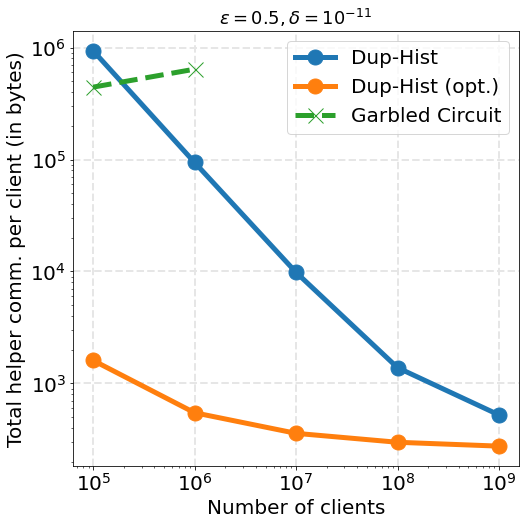

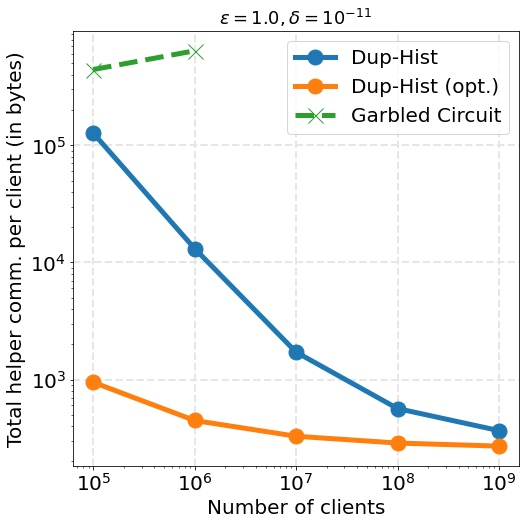

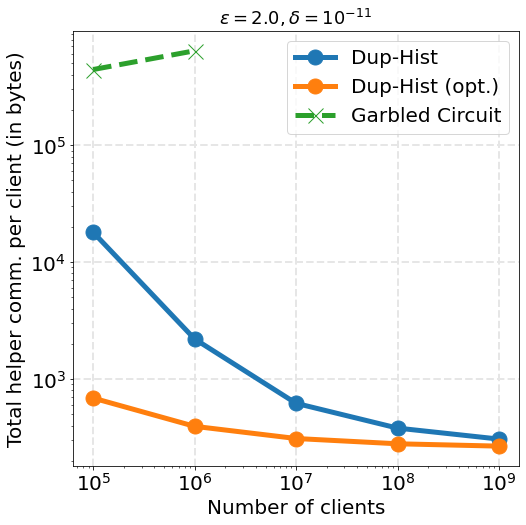

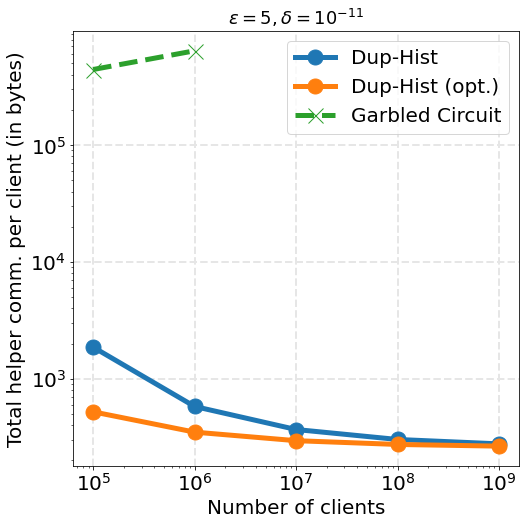

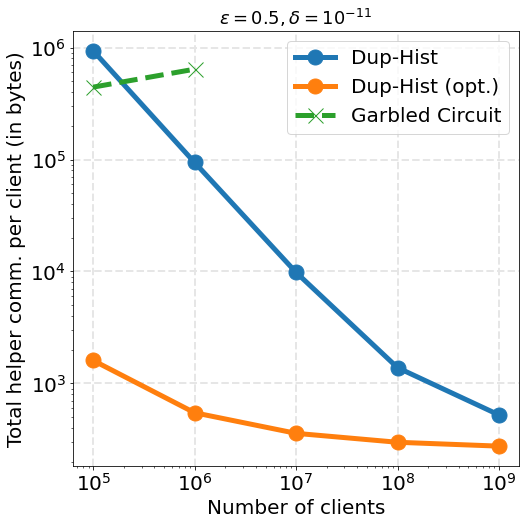

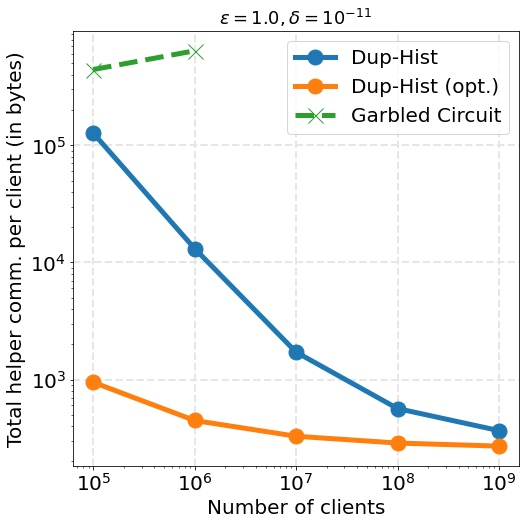

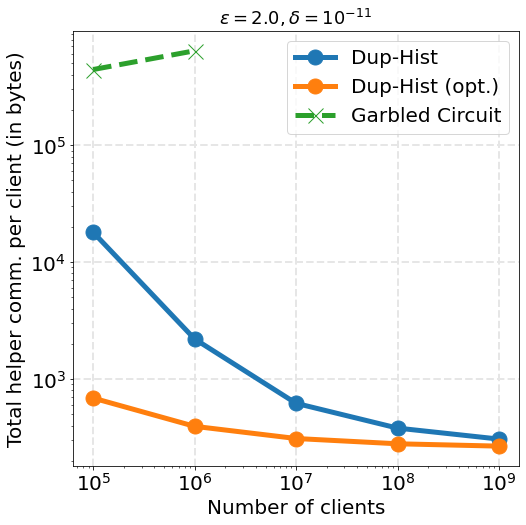

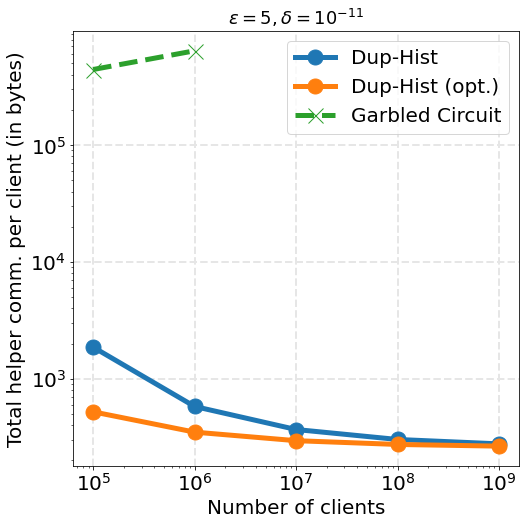

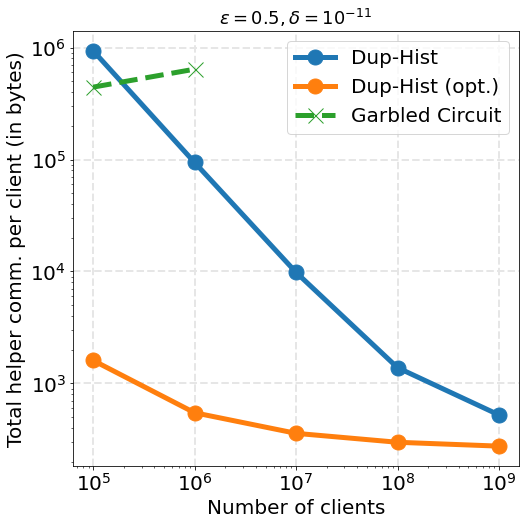

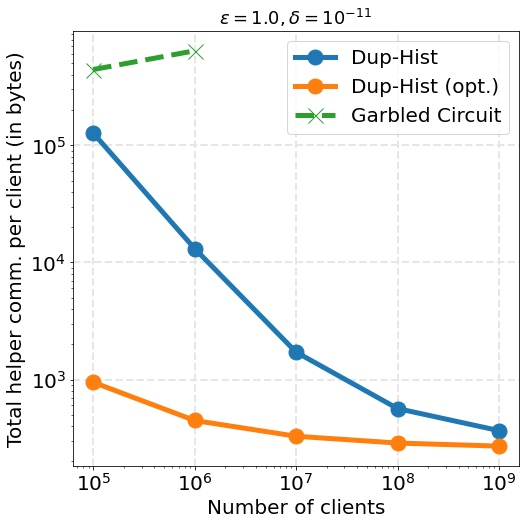

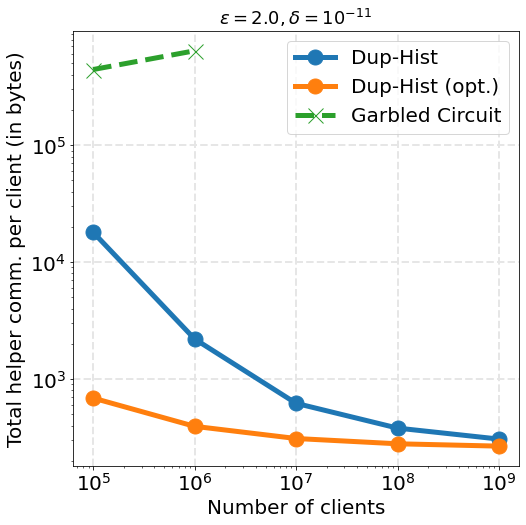

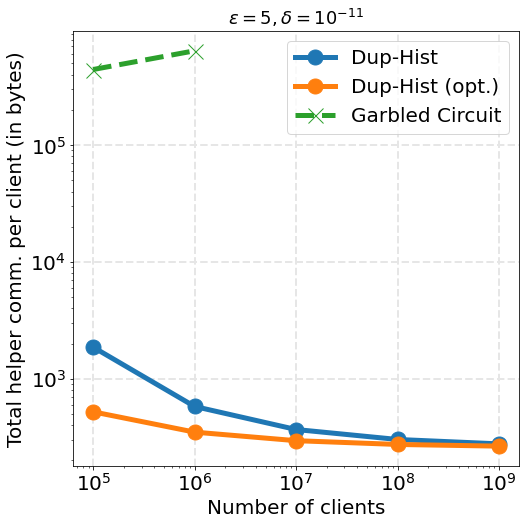

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc

matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['figure.titlesize'] = 18
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['lines.linewidth'] = 5
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['legend.facecolor'] = 'white'
matplotlib.rcParams['legend.framealpha'] = 0.8


def format_float(input):
  split = '{:.0e}'.format(input).split('e')
  if len(split) > 1:
    while split[1][1] == '0':
      split[1] = split[1][0] + split[1][2:]
    if split[1][0] == '+':
      split[1] = split[1][1:]
    if split[0] == '1':
      return '10^{{{}}}'.format(split[1])
    return '{}\\cdot 10^{{{}}}'.format(*split)
  return str(input)


show_GC = True
DEBUG = True
# GC size (in number of AND gates) for n = 10^3 - 10^6, obtained using the EMP framework.
gc_and_gates = np.array([5399820, 89523380, 1386896724, 20057690628])
gc_and_gates_client = np.array([
    5399820 / 1000, 89523380 / 10000, 1386896724 / 100000, 20057690628 / 1000000
])
bytes_per_and_gate = 32
num_dummies = dict()
ns = [10**i for i in range(5, 10)]
for log2_domain_size in [32, 64, 128]:
  for eps in [.5, 1., 2., 5]:
    fig = plt.figure()
    comm_client_hh = []
    comm_client_dup = []
    comm_client_dup_clones = []
    h_mult = 10
    for n in ns:
      h = np.ceil(h_mult * np.log(n))
      delta = 10**(-11)
      if DEBUG:
        print('n = {}'.format(n))
        print('-' * 20)
        print('h = {}'.format(h))

      hist_dup = Dup_Hist(eps, delta, n, log2_domain_size, False)
      comm_client_dup.append(hist_dup.get_expected_comm(unit='bytes')[1] / n)
      if DEBUG:
        print('\tComm. per client (bytes) = {}'.format(comm_client_dup[-1]))
        print('-' * 20)
      hist_dup_clones = Dup_Hist(eps, delta, n, log2_domain_size, True)
      comm_client_dup_clones.append(
          hist_dup_clones.get_expected_comm(unit='bytes')[1] / n)
      num_dummies[(n, eps)] = (
          hist_dup_clones.expected_num_dummies_step_2,
          hist_dup_clones.expected_num_dummies_for_thresholding_in_step_3,
          hist_dup_clones.tau, hist_dup_clones.T)
      if DEBUG:
        print('\tComm. per client (bytes) = {}'.format(
            comm_client_dup_clones[-1]))
        print('-' * 20)

    plt.plot(ns, comm_client_dup, label='Dup-Hist', marker='o', linestyle='-')
    plt.plot(
        ns,
        comm_client_dup_clones,
        label='Dup-Hist (opt.)',
        marker='o',
        linestyle='-')
    if show_GC:
      plt.plot([10**i for i in range(5, 7)],
               (gc_and_gates_client * bytes_per_and_gate)[2:],
               label='Garbled Circuit',
               marker='x',
               linestyle='--')

    plt.legend()
    plt.title('$\epsilon = {}, \delta = {}$'.format(eps, format_float(delta)))
    plt.xlabel('Number of clients')
    plt.ylabel('Total helper comm. per client (in bytes)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, lw=2, ls='--', c='.90')

In [4]:
# (n, epsilon) -> (num_dummies_step_2, num_dummies_step_3, tau, T)
for k, v in num_dummies.items():
  print("{}: {},".format(k, v))

(100000, 0.5): (701333.0, 217, 431.9305630027929, 10),
(1000000, 0.5): (1511798.0, 217, 431.9305630027929, 12),
(10000000, 0.5): (5286583.0, 217, 431.9305630027929, 27),
(100000000, 0.5): (21612639.0, 217, 431.9305630027929, 57),
(1000000000, 0.5): (97689180.0, 217, 431.9305630027929, 105),
(100000, 1.0): (359734.0, 111, 218.67875912810138, 4),
(1000000, 1.0): (991509.0, 111, 218.67875912810138, 7),
(10000000, 1.0): (3712829.0, 111, 218.67875912810138, 17),
(100000000, 1.0): (15744792.0, 111, 218.67875912810138, 36),
(1000000000, 1.0): (69629491.0, 111, 218.67875912810138, 81),
(100000, 2.0): (224616.0, 58, 112.59404485814969, 2),
(1000000, 2.0): (717139.0, 58, 112.59404485814969, 4),
(10000000, 2.0): (2794539.0, 58, 112.59404485814969, 9),
(100000000, 2.0): (12001126.0, 58, 112.59404485814969, 18),
(1000000000, 2.0): (54117247.0, 58, 112.59404485814969, 44),
(100000, 5): (137113.0, 26, 49.6452776831737, 1),
(1000000, 5): (476665.0, 26, 49.6452776831737, 2),
(10000000, 5): (1951010.0, 

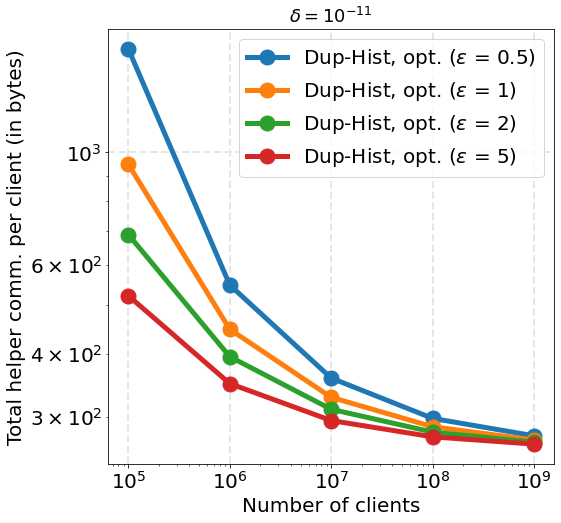

In [5]:
import matplotlib.pyplot as plt

show_GC = False
plot_hh = False
DEBUG = False
ns = [10**i for i in range(5, 10)]
delta = 10**(-11)

fig = plt.figure()
for eps in [.5, 1, 2, 5]:
  comm_client_dup = []
  comm_client_dup_clones = []
  for n in ns:
    hist_dup = Dup_Hist(eps, delta, n, log2_domain_size, False)
    comm_client_dup.append(hist_dup.get_expected_comm(unit='bytes')[1] / n)
    hist_dup_clones = Dup_Hist(eps, delta, n, log2_domain_size, True)
    comm_client_dup_clones.append(
        hist_dup_clones.get_expected_comm(unit='bytes')[1] / n)
  plt.plot(
      ns,
      comm_client_dup_clones,
      label='Dup-Hist, opt. ($\epsilon$ = {})'.format(eps),
      marker='o',
      linestyle='-')
  plt.legend()
  plt.title('$\delta = {}$'.format(format_float(delta)))
  plt.xlabel('Number of clients')
  plt.ylabel('Total helper comm. per client (in bytes)')
  plt.xscale('log')
  plt.yscale('log')
  plt.grid(True, lw=2, ls='--', c='.90')

### Running time and communication
Generates plots and tables for the paper

HE scheme: ExponentialElGamal
Client computation: 0.46 ms, communication: 192 bytes

$\varepsilon$ & $n$ & {{\pone offline}} & {{\pone online}} & {{\pone total}} & {{\pone comm.}} & {{\ptwo offline}} & {{\ptwo online}} & {{\ptwo total}} & {{\ptwo comm.}} & {{total time}} & {{total comm.}} \\
\midrule
\multirow{5}{*}{$0.5$} & $10^{5}$ & 4.13 & 1.13 & 5.25 & 1539 & 0.46 & 1.38 & 1.83 & 64 & 7.09 & 1603 \\
 & $10^{6}$ & 1.61 & 0.56 & 2.17 & 482 & 0.46 & 0.54 & 0.99 & 64 & 3.16 & 547 \\
 & $10^{7}$ & 1.16 & 0.46 & 1.62 & 294 & 0.46 & 0.39 & 0.84 & 64 & 2.46 & 358 \\
 & $10^{8}$ & 1.01 & 0.43 & 1.44 & 234 & 0.46 & 0.34 & 0.80 & 64 & 2.24 & 298 \\
 & $10^{9}$ & 0.96 & 0.42 & 1.38 & 211 & 0.46 & 0.32 & 0.78 & 64 & 2.16 & 275 \\
\midrule
\multirow{5}{*}{$1.0$} & $10^{5}$ & 2.56 & 0.78 & 3.34 & 883 & 0.46 & 0.85 & 1.31 & 64 & 4.65 & 947 \\
 & $10^{6}$ & 1.37 & 0.51 & 1.88 & 382 & 0.46 & 0.46 & 0.91 & 64 & 2.79 & 447 \\
 & $10^{7}$ & 1.09 & 0.45 & 1.53 & 263 & 0.46 & 0.36 & 0.82 & 64 & 2.35 & 32

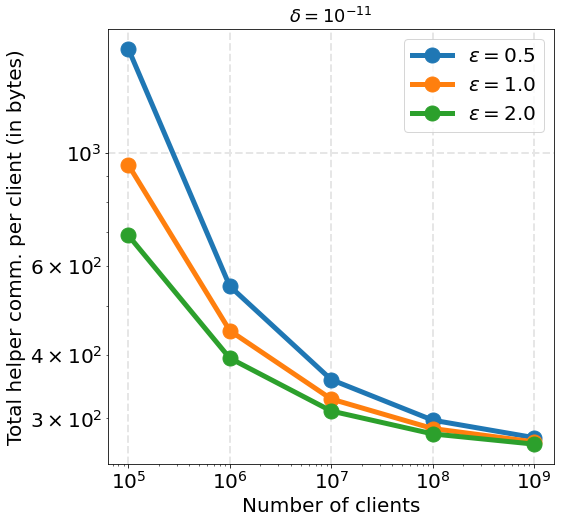

Total CPU time per client (ms)


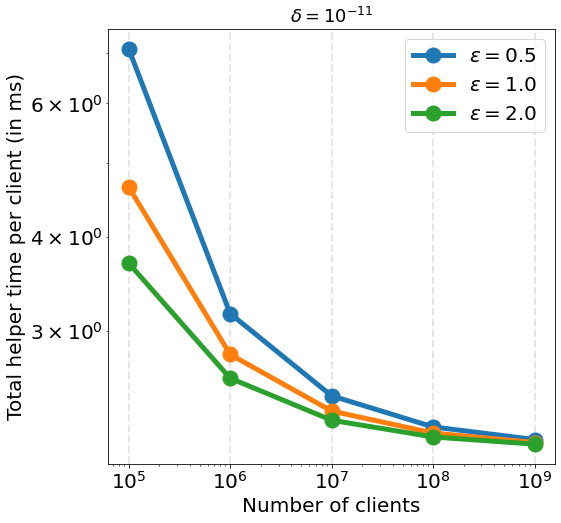

HE scheme: Paillier
Client computation: 1.23 ms, communication: 384 bytes

$\varepsilon$ & $n$ & {{\pone offline}} & {{\pone online}} & {{\pone total}} & {{\pone comm.}} & {{\ptwo offline}} & {{\ptwo online}} & {{\ptwo total}} & {{\ptwo comm.}} & {{total time}} & {{total comm.}} \\
\midrule
\multirow{5}{*}{$0.5$} & $10^{5}$ & 11.04 & 1.68 & 12.72 & 3077 & 2.76 & 1.40 & 4.16 & 257 & 16.88 & 3334 \\
 & $10^{6}$ & 4.30 & 1.10 & 5.41 & 965 & 2.76 & 0.55 & 3.31 & 256 & 8.71 & 1221 \\
 & $10^{7}$ & 3.10 & 1.00 & 4.10 & 587 & 2.76 & 0.40 & 3.16 & 256 & 7.26 & 843 \\
 & $10^{8}$ & 2.71 & 0.97 & 3.68 & 467 & 2.76 & 0.35 & 3.11 & 256 & 6.79 & 723 \\
 & $10^{9}$ & 2.57 & 0.96 & 3.53 & 422 & 2.76 & 0.33 & 3.09 & 256 & 6.62 & 678 \\
\midrule
\multirow{5}{*}{$1.0$} & $10^{5}$ & 6.86 & 1.32 & 8.18 & 1766 & 2.76 & 0.87 & 3.63 & 257 & 11.81 & 2022 \\
 & $10^{6}$ & 3.66 & 1.05 & 4.71 & 765 & 2.76 & 0.47 & 3.23 & 256 & 7.94 & 1021 \\
 & $10^{7}$ & 2.90 & 0.98 & 3.89 & 527 & 2.76 & 0.38 & 3.13 & 256 & 7.0

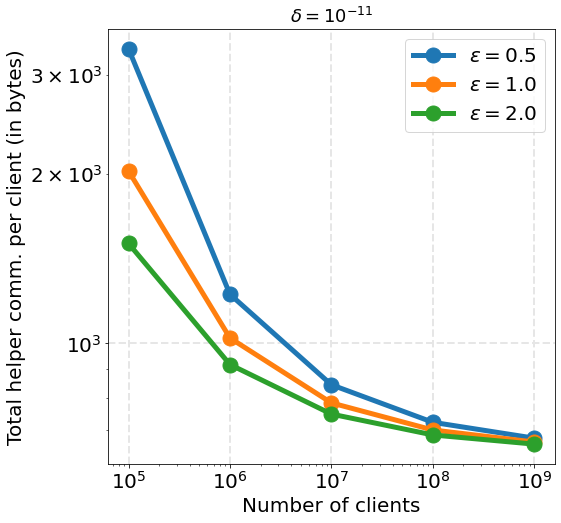

Total CPU time per client (ms)


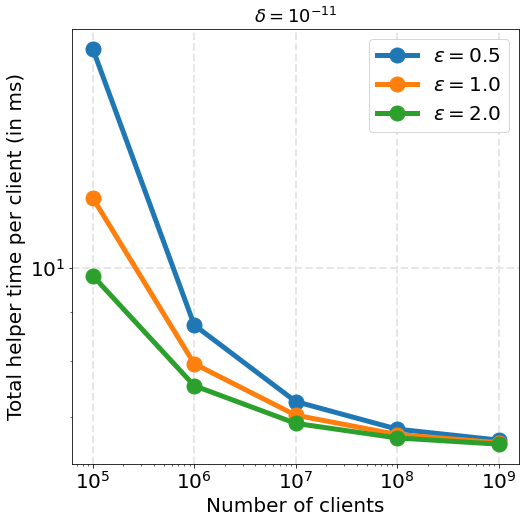

In [6]:
ns = np.unique([n for n, eps in num_dummies])
epsilons = np.unique([eps for n, eps in num_dummies])[:-1]
he_modes = ["ExponentialElGamal", "Paillier"]
parties = ["Client", "Helper 1", "Helper 2"]
delta = 10**(-11)


def protocol(party, n, epsilon, he_mode):
  hist_dup = Dup_Hist(
      epsilon, delta, n, log2_domain_size, True, he_mode=he_mode)
  offline_time, online_time = hist_dup.get_expected_computation({party})
  _, bytes_sent = hist_dup.get_expected_comm(unit="bytes", parties={party})
  return (offline_time, online_time, bytes_sent)


for he_mode in he_modes:
  data = np.array(([[[protocol(party, n, epsilon, he_mode)
                      for n in ns]
                     for epsilon in epsilons]
                    for party in parties]))
  data_per_client = data / ns.reshape((1, 1, ns.size, 1))  # Divide by n.
  print("HE scheme: {}".format(he_mode))

  # Print client cost. It's independent of epsilon and n.
  print("Client computation: {:.2f} ms, communication: {:.0f} bytes".format(
      np.sum(data_per_client[0, 0, 0, :2] * 1000, axis=-1), data_per_client[0, 0, 0, -1]))

  # Print table
  # Columns: offline_time_p1, online_time_p1, total_time_p1, bytes_p1, offline_time_p2, online_time_p2, total_time_p2, bytes_p2, total_time, total_bytes
  # Rows: Epsilon
  print()
  print(
      "$\\varepsilon$ & $n$ & {{\\pone offline}} & {{\\pone online}} & {{\\pone total}} & {{\\pone comm.}} & {{\\ptwo offline}} & {{\\ptwo online}} & {{\\ptwo total}} & {{\\ptwo comm.}} & {{total time}} & {{total comm.}} \\\\"
  )
  print("\\midrule")
  for i_eps, epsilon in enumerate(epsilons):
    for i_n, n in enumerate(ns):
      print(
          "{} & {} & {:.2f} & {:.2f} & {:.2f} & {:.0f} & {:.2f} & {:.2f} & {:.2f} & {:.0f} & {:.2f} & {:.0f} \\\\"
          .format(
              "\multirow{{5}}{{*}}{{${}$}}".format(epsilon) if i_n == 0 else "",
              "${}$".format(format_float(n)),
              data_per_client[1, i_eps, i_n, 0] * 1000,  # ms
              data_per_client[1, i_eps, i_n, 1] * 1000,
              np.sum(data_per_client[1, i_eps, i_n, :2], axis=-1) * 1000,
              data_per_client[1, i_eps, i_n, 2],
              data_per_client[2, i_eps, i_n, 0] * 1000,
              data_per_client[2, i_eps, i_n, 1] * 1000,
              np.sum(data_per_client[2, i_eps, i_n, :2], axis=-1) * 1000,
              data_per_client[2, i_eps, i_n, 2],
              np.sum(data_per_client[1:, i_eps, i_n, :2], axis=(0, -1)) * 1000,
              np.sum(data_per_client[1:, i_eps, i_n, 2], axis=0)))
    if i_n == len(ns) - 1 and i_eps != len(epsilons) - 1:
      print("\\midrule")
  print()

  # Plot total communication, summed over parties
  print("Total CPU time per client (ms)")
  for i_eps, epsilon in enumerate(epsilons):
    plt.plot(
        ns,
        np.sum(data_per_client[1:, i_eps, :, 2], axis=0),
        label="$\epsilon = {}$".format(epsilon),
        marker="o")
  plt.xscale("log")
  plt.yscale("log")
  plt.title("$\delta = {}$".format(format_float(delta)))
  plt.legend()
  plt.grid(True, lw=2, ls="--", c=".90")
  plt.xlabel("Number of clients")
  plt.ylabel("Total helper comm. per client (in bytes)")
  plt.show()

  # Plot total time, summed over parties
  print("Total CPU time per client (ms)")
  for i_eps, epsilon in enumerate(epsilons):
    plt.plot(
        ns,
        np.sum(data_per_client[1:, i_eps, :, 0:2] * 1000, axis=(0, -1)),
        label="$\epsilon = {}$".format(epsilon),
        marker="o")
  plt.xscale("log")
  plt.yscale("log")
  plt.title("$\delta = {}$".format(format_float(delta)))
  plt.legend()
  plt.grid(True, lw=2, ls="--", c=".90")
  plt.xlabel("Number of clients")
  plt.ylabel("Total helper time per client (in ms)")
  plt.show()

### Comparison of HH_Hist and Dup_Hist

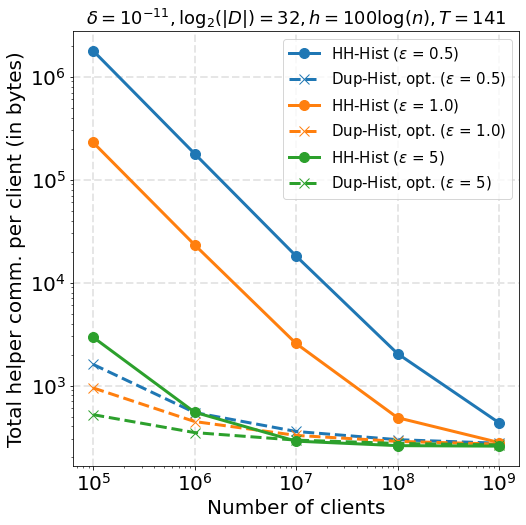

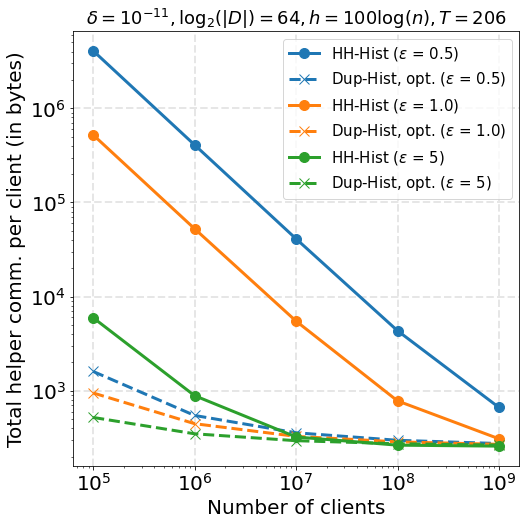

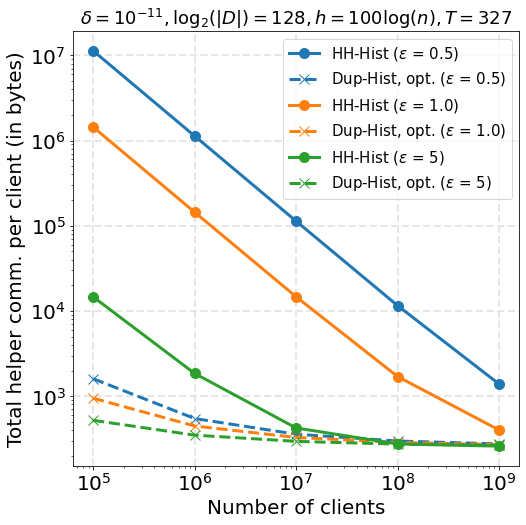

In [7]:
from algorithms import HH_Hist
from budget_split_optimization import optimize_budget_split

matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['lines.markersize'] = 10
matplotlib.rcParams['lines.linewidth'] = 3

DEBUG = False
ns = [10**i for i in range(5, 10)]
for log2_domain_size in [32, 64, 128]:
  fig = plt.figure()
  for eps in [.5, 1., 5]:
    comm_client_hh = []
    comm_client_dup_clones = []
    h_mult = 100
    for n in ns:
      h = np.ceil(h_mult*np.log(n))
      delta = 10**(-11)

      optimal_budget_split, _ = optimize_budget_split(
          epsilon=eps, delta=delta, n=n, log2_domain_size=log2_domain_size, h=h)
      hist_hh = HH_Hist(
          epsilon=eps, delta=delta, n=n, log2_domain_size=log2_domain_size, h=h,
          budget_split=optimal_budget_split)
      comm_client_hh.append(hist_hh.get_expected_comm(unit='bytes')[1] / n)

      hist_dup_clones = Dup_Hist(eps, delta, n, log2_domain_size, True)
      comm_client_dup_clones.append(hist_dup_clones.get_expected_comm(unit='bytes')[1] / n)


    p = plt.plot(ns, comm_client_hh,
                  label='HH-Hist ($\epsilon$ = {})'.format(eps),
                  marker='o',
                  linestyle='-')

    plt.plot(ns, comm_client_dup_clones,
                label='Dup-Hist, opt. ($\epsilon$ = {})'.format(eps),
                marker='x',
                linestyle='--',
                color = p[0].get_color())


    plt.legend()
    plt.title('$\delta = {}, \log_2(|D|) = {}, h = {}, T = {}$'.format(
                    format_float(delta), log2_domain_size, '{}\log(n)'.format(h_mult), int(hist_hh.T)))

    plt.xlabel('Number of clients')
    plt.ylabel('Total helper comm. per client (in bytes)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, lw = 2, ls = '--', c = '.90')